In [65]:
import pyspark
from pyspark.sql import SQLContext, Row
import pandas.io.data as web
import datetime

In [5]:
import datetime
from collections import namedtuple

In [2]:
sc = pyspark.SparkContext('local', 'pyspark')

In [3]:
sqlContext = SQLContext(sc) 

### VaR computation for single risk factor / scenario set

In [150]:
Simulation = namedtuple('Simulation', ('date', 'neutral', 'scenarios'))
RFScenario = namedtuple('RFScenario', ('rf', 'date', 'neutral', 'scenarios'))

In [149]:
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector, _convert_to_vector 
def parse(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = datetime.datetime.strptime(row[0], DATE_FMT)
    for i in np.arange(1,len(row)):
        row[i] = float(row[i])
    return Simulation(row[0], row[1], DenseVector(row[2:]))


def parse2(row):
    DATE_FMT = "%Y-%m-%d"
    row[0] = row[0]
    row[1] = datetime.datetime.strptime(row[1], DATE_FMT)
    for i in np.arange(2,len(row)):
        row[i] = float(row[i])
#     return row
    return RFScenario(row[0], row[1], row[2], DenseVector(row[3:6]))

# test
# s = "2015-05-08,32.42,32.864847227683306,32.50044000839989,31.962723820560473,31.920709606792094,32.528263796919845,31.86562405274838,32.136619526291824,32"
# datetime.datetime.strptime( s.split(',')[0], '%Y-%m-%d')
# float( s.split(',')[1])

Scenarios are already available. We will load the csv file into Spark (no Big Data here to see, move along).

In [175]:
csv_filename = "../data/scenarios.csv"

In [155]:
lines = sc.textFile(csv_filename)
parts = lines.map(lambda l: l.split(","))
rows = parts.map(parse)

In [156]:
df = sqlContext.createDataFrame(rows)

In [158]:
df.show()

date                 neutral scenarios           
2015-04-14 00:00:... 35.03   [34.6786591247593...
2015-04-15 00:00:... 35.2    [35.3591001198495...
2015-04-16 00:00:... 34.25   [34.8632736442283...
2015-04-17 00:00:... 33.3    [33.1795757719794...
2015-04-20 00:00:... 33.4    [33.6645907080361...
2015-04-21 00:00:... 33.34   [33.1894036235088...
2015-04-22 00:00:... 33.95   [33.6959580275939...
2015-04-23 00:00:... 34.15   [33.5071140633566...
2015-04-24 00:00:... 34.26   [34.5664326197202...
2015-04-27 00:00:... 32.61   [33.4607445304432...
2015-04-28 00:00:... 32.04   [31.6475326995588...
2015-04-29 00:00:... 31.73   [31.8891942070903...
2015-04-30 00:00:... 32.1    [31.7192402890532...
2015-05-01 00:00:... 32.29   [31.8955691707124...
2015-05-04 00:00:... 32.09   [31.2125357673158...
2015-05-05 00:00:... 31.51   [31.6754560380150...
2015-05-06 00:00:... 32.26   [32.5394251070606...
2015-05-07 00:00:... 32.05   [31.6599990486603...
2015-05-08 00:00:... 32.42   [32.8648472276833...


In [159]:
df.describe()

DataFrame[summary: string, neutral: double]

Now let's compute the VaR for each day.

In [43]:
def var(scenarios, level=99, neutral_scenario=0):
    pnls = scenarios - neutral_scenario
    return - np.percentile(pnls, 100-level, interpolation='linear')

In [161]:
pnls = df.map( lambda r: {'date': r.date,
                          'neutral': r.neutral,
                          'var': float(var(r.scenarios.array, neutral_scenario=r.neutral))})

In [162]:
a = sqlContext.createDataFrame(pnls)

<IPython.core.display.Javascript object>


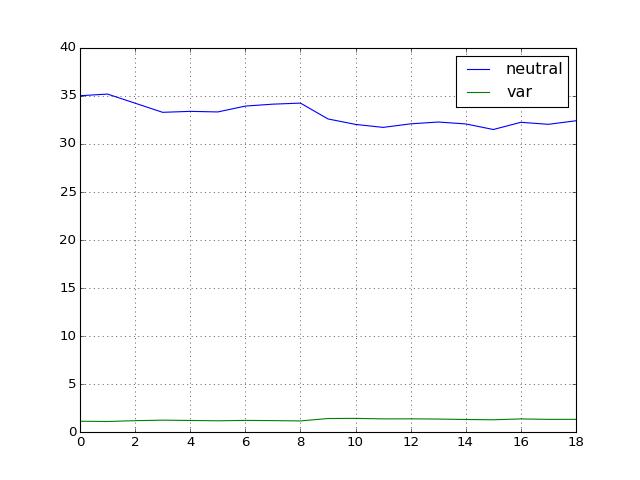

In [164]:
%matplotlib notebook
a.toPandas().plot();

## Example with a portfolio

where the scenarios must be summed up.

In [184]:
csv_filename = "/Users/miguel/Jottacloud/devel/osqf2015/data/scenarios2.csv"

In [185]:
scenarios_rdd = sc.textFile(csv_filename).map(lambda l: l.split(",")).map(parse2)

In [186]:
scenarios_rdd.takeSample(False, 1,0)

[RFScenario(rf=u'RF2', date=datetime.datetime(2015, 4, 24, 0, 0), neutral=34.26, scenarios=DenseVector([34.5664, 34.9539, 33.9295]))]

In [188]:
dfs = sqlContext.createDataFrame(scenarios_rdd)

Define one portfolio

In [189]:
pf_rdd = sc.parallelize([('RF1', 1.), ('RF2', 2.)])
dfpf = sqlContext.createDataFrame(pf_rdd, ['rf', 'qty'])

In [191]:
res = dfs.join(dfpf, dfpf.rf == dfs.rf).select(dfs.rf, dfpf.qty, dfs.date, dfs.neutral, dfs.scenarios)

In [192]:
pf_values = res.map(lambda r: Row(date=r.date,
                                  neutral=r.neutral*r.qty,
                                  scenarios=DenseVector(r.scenarios.array * r.qty)))
aaa = pf_values.map(lambda x: (x[0], (x[1],x[2]))).aggregateByKey(0, lambda v, d: d, lambda x,y: (x[0]+y[0], x[1]+y[1])).map(lambda r: Row(date=r[0], neutral=r[1][0], scenarios=r[1][1]))

In [193]:
df_res = sqlContext.createDataFrame(aaa)

In [195]:
pnls = df_res.map( lambda r: {'date': r.date,
                          'neutral': r.neutral,
                          'var': float(var(r.scenarios.array, neutral_scenario=r.neutral))}).toDF().toPandas()

<IPython.core.display.Javascript object>


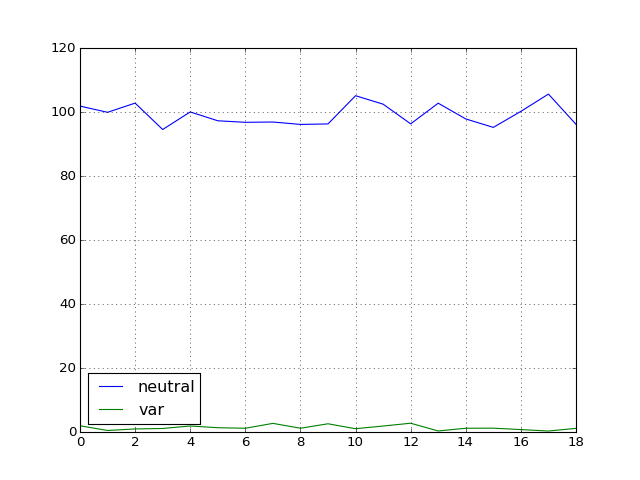

In [196]:
%matplotlib notebook
pnls.plot()

In [198]:
df_vals.groupBy('date').agg({'neutral': 'sum'}).collect()

[Row(date=datetime.datetime(2015, 4, 16, 0, 0), SUM(neutral)=102.75),
 Row(date=datetime.datetime(2015, 4, 28, 0, 0), SUM(neutral)=96.12),
 Row(date=datetime.datetime(2015, 4, 27, 0, 0), SUM(neutral)=97.83),
 Row(date=datetime.datetime(2015, 4, 21, 0, 0), SUM(neutral)=100.02000000000001),
 Row(date=datetime.datetime(2015, 4, 17, 0, 0), SUM(neutral)=99.89999999999999),
 Row(date=datetime.datetime(2015, 4, 14, 0, 0), SUM(neutral)=105.09),
 Row(date=datetime.datetime(2015, 4, 22, 0, 0), SUM(neutral)=101.85000000000001),
 Row(date=datetime.datetime(2015, 4, 24, 0, 0), SUM(neutral)=102.78),
 Row(date=datetime.datetime(2015, 4, 23, 0, 0), SUM(neutral)=102.44999999999999),
 Row(date=datetime.datetime(2015, 4, 20, 0, 0), SUM(neutral)=100.19999999999999),
 Row(date=datetime.datetime(2015, 4, 15, 0, 0), SUM(neutral)=105.60000000000001),
 Row(date=datetime.datetime(2015, 4, 30, 0, 0), SUM(neutral)=96.30000000000001),
 Row(date=datetime.datetime(2015, 5, 6, 0, 0), SUM(neutral)=96.78),
 Row(date=da

### Interesting links

http://www.slideshare.net/BenjaminBengfort/fast-data-analytics-with-spark-and-python
https://spark.apache.org/docs/latest/sql-programming-guide.html#programmatically-specifying-the-schema
    